# Theme Park Optimization - Canada's Wonderland

## Problem Statement
Optimize a theme park visit to minimize total time spent while maximizing preference value of visited attractions, considering:
- Time-dependent wait times throughout the day
- Walking distances between attractions
- Individual ride durations
- Visitor preferences for different attractions

This is an extension of the Traveling Salesman Problem with additional complexity.

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms

# Set up visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Simplified Model Setup

### Decision Variables
- $x_i$ : Binary variable indicating whether attraction $i$ is visited (1) or skipped (0)
- $y_{ij}$ : Binary variable indicating travel from attraction $i$ to attraction $j$
- $t_i$ : Continuous variable for the time when we arrive at attraction $i$

### Objective Functions

**Objective 1: Weighted Time-Preference Trade-off**
$$\text{Maximize: } \sum_{i} (\text{preference}_i \cdot x_i) - \alpha \cdot \text{total\_time}$$

Where:
- $\alpha$ is a weighting factor balancing preference vs. time
- total_time includes wait times, ride durations, and walking times

**Objective 2: Maximum Utility (Time-Constrained)**
$$\text{Maximize: } \sum_{i} (\text{preference}_i \cdot x_i)$$
$$\text{Subject to: } \text{total\_time} \leq 12 \text{ hours (720 minutes)}$$

This formulation maximizes total preference scores while ensuring the entire itinerary fits within park operating hours.

In [3]:
# Load attraction data from CSV
df_attractions = pd.read_csv('data/attractions_full.csv')
df_attractions = df_attractions.set_index('id')
print("Attractions:")
print(df_attractions)
print(f"\nTotal attractions: {len(df_attractions)}")

Attractions:
                          name  ride_duration  preference
id                                                       
1                    AlpenFury           1.33          10
2        Backlot Stunt Coaster           1.06           6
3                     Behemoth           3.17           8
4                  Dragon Fyre           1.50           5
5                  Flight Deck           1.47           1
6              Ghoster Coaster           1.33           1
7                    Leviathan           3.47           9
8   Mighty Canadian Minebuster           2.06           4
9                Silver Streak           1.27           1
10     Snoopy's Racing Railway           1.20          10
11                    Taxi Jam           0.92           1
12                     The Bat           1.80           4
13                     The Fly           1.80           1
14                 Thunder Run           1.40           1
15                      Vortex           1.60           7
1

In [4]:
# Load distance matrix from CSV (n x n format)
df_distances_raw = pd.read_csv('data/distances_full.csv', index_col=0)

# Validation: Check if matrix is square
n_rows, n_cols = df_distances_raw.shape
if n_rows != n_cols:
    raise ValueError(f"Distance matrix is not square: expected N×N, got {n_rows}×{n_cols}")

# Validation: Check if size matches (n_attractions + 1 for entrance)
expected_size = len(df_attractions) + 1
if n_rows != expected_size:
    raise ValueError(
        f"Distance matrix size mismatch: expected {expected_size}×{expected_size} "
        f"({len(df_attractions)} attractions + entrance), got {n_rows}×{n_rows}"
    )

# Validation: Check if matrix is symmetric
distance_matrix = df_distances_raw.values
if not np.allclose(distance_matrix, distance_matrix.T):
    # Find first asymmetric entry for helpful error message
    for i in range(n_rows):
        for j in range(i+1, n_cols):
            if not np.isclose(distance_matrix[i, j], distance_matrix[j, i]):
                raise ValueError(
                    f"Distance matrix is not symmetric: "
                    f"distance from ID {i} to ID {j} ({distance_matrix[i, j]}) != "
                    f"distance from ID {j} to ID {i} ({distance_matrix[j, i]})"
                )

print("✓ Distance matrix validation passed")
print(f"  - Matrix is square: {n_rows}×{n_cols}")
print(f"  - Matrix is symmetric")
print(f"  - Size matches: {len(df_attractions)} attractions + 1 entrance")

# Create mapping: ID -> Name (0 is Entrance, 1-N are attractions)
id_to_name = {0: 'Entrance'}
id_to_name.update(df_attractions['name'].to_dict())

# Create DataFrame with names as labels for readability
location_names = [id_to_name[int(id)] for id in df_distances_raw.index]
df_distances = pd.DataFrame(distance_matrix, 
                            columns=location_names,
                            index=location_names)

n_attractions = len(df_attractions)
print("\nWalking distances (m):")
print(df_distances)

✓ Distance matrix validation passed
  - Matrix is square: 27×27
  - Matrix is symmetric
  - Size matches: 26 attractions + 1 entrance

Walking distances (m):
                            Entrance  AlpenFury  Backlot Stunt Coaster  \
Entrance                           0          0                      0   
AlpenFury                          0          0                    550   
Backlot Stunt Coaster              0        550                      0   
Behemoth                           0        550                     16   
Dragon Fyre                        0        450                    900   
Flight Deck                        0        550                    500   
Ghoster Coaster                    0        400                    900   
Leviathan                          0        260                    800   
Mighty Canadian Minebuster         0        500                    300   
Silver Streak                      0        450                    750   
Snoopy's Racing Railway     

In [5]:
# Load wait time data from CSV
df_wait_times_raw = pd.read_csv('data/wait_times_full.csv')
df_wait_times_raw = df_wait_times_raw.set_index('id')

# Get hours from column names (converting to int)
hours = [int(col) for col in df_wait_times_raw.columns]

# Create a DataFrame with attraction names for display
df_wait_times = df_wait_times_raw.copy()
df_wait_times.index = df_wait_times.index.map(lambda id: df_attractions.loc[id, 'name'])

# Convert to dictionary format for easier access in functions
# Using attraction names as keys for compatibility with existing functions
wait_times = {}
for attraction_id in df_wait_times_raw.index:
    attraction_name = df_attractions.loc[attraction_id, 'name']
    wait_times[attraction_name] = df_wait_times_raw.loc[attraction_id].tolist()

print("\nWait times by hour (minutes):")
print(df_wait_times)


Wait times by hour (minutes):
                            900  930  1000  1030  1100  1130  1200  1230  \
id                                                                         
AlpenFury                    66   87   127   153   152   144   135   119   
Backlot Stunt Coaster        10   10    12    12    21    26    27    26   
Behemoth                      7    7     7    10    16    21    28    30   
Dragon Fyre                   6    5     6     5     6     7     8     9   
Flight Deck                   4    4     4     4     6     9     8    11   
Ghoster Coaster               5    5     8     8    15    22    28    30   
Leviathan                    20   22    24    30    46    55    55    52   
Mighty Canadian Minebuster   15   15    15    18    28    36    38    39   
Silver Streak                 5    5    14    14     6     7     7    11   
Snoopy's Racing Railway      10   10    19    20    21    28    35    39   
Taxi Jam                      2    4     6    15    12   

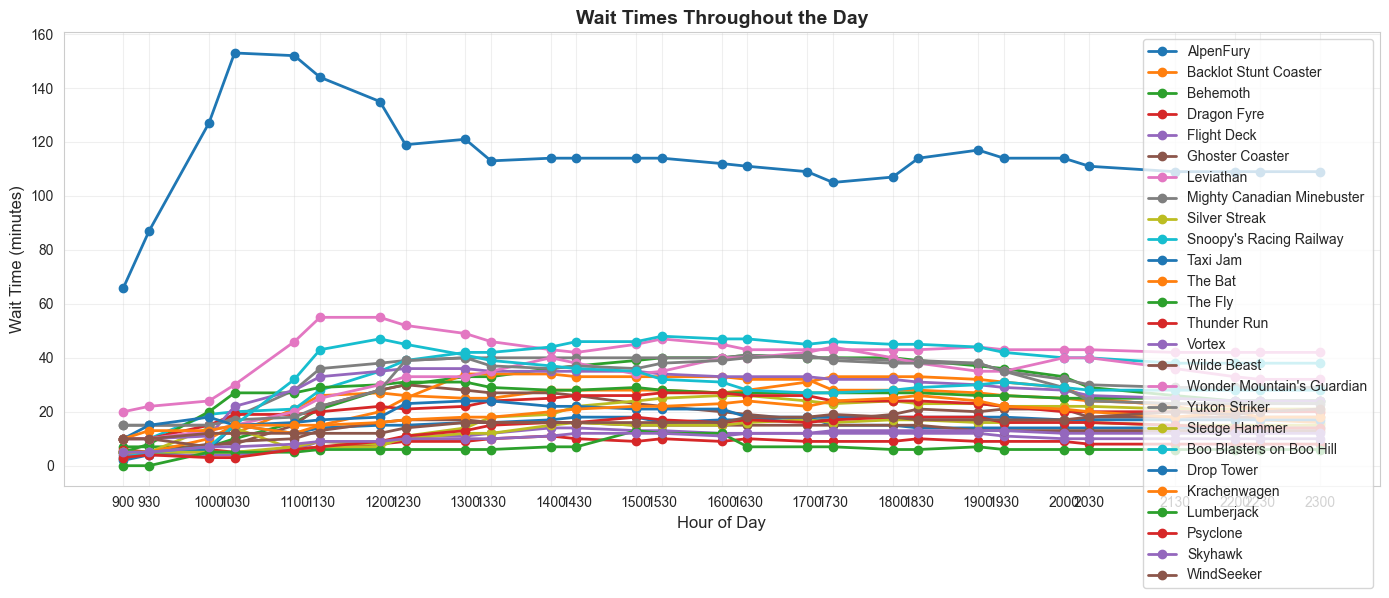

In [6]:
# Visualize wait times throughout the day
plt.figure(figsize=(14, 6))
for attraction in wait_times.keys():
    plt.plot(hours, wait_times[attraction], marker='o', label=attraction, linewidth=2)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Wait Time (minutes)', fontsize=12)
plt.title('Wait Times Throughout the Day', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(hours)
plt.tight_layout()
plt.show()

## Problem Parameters

In [18]:
# Park parameters
PARK_OPEN = 9  # 9am
PARK_CLOSE = 21  # 9pm
AVAILABLE_HOURS = PARK_CLOSE - PARK_OPEN
MAX_TIME_MINUTES = AVAILABLE_HOURS * 60  # Maximum time constraint

# Personal Paramaters
WALK_SPEED = 6
# Optimization parameters
ALPHA = 0.5  # Weight for time penalty (tune this) - for Objective 1
MIN_ATTRACTIONS = 3  # Minimum number of attractions to visit

print(f"Park operating hours: {PARK_OPEN}:00 to {PARK_CLOSE}:00")
print(f"Available time: {AVAILABLE_HOURS} hours ({MAX_TIME_MINUTES} minutes)")
print(f"Number of attractions: {n_attractions}")
print(f"\nObjective 1 parameters:")
print(f"  - Time penalty weight (alpha): {ALPHA}")
print(f"\nObjective 2 parameters:")
print(f"  - Maximum time constraint: {MAX_TIME_MINUTES} minutes")

Park operating hours: 9:00 to 21:00
Available time: 12 hours (720 minutes)
Number of attractions: 26

Objective 1 parameters:
  - Time penalty weight (alpha): 0.5

Objective 2 parameters:
  - Maximum time constraint: 720 minutes


## Helper Functions

In [8]:
def get_wait_time(attraction_name, hour):
    """
    Get wait time for an attraction at a specific hour.
    Uses linear interpolation for fractional hours.
    """
    hour_floor = int(np.floor(hour))
    hour_ceil = int(np.ceil(hour))
    
    # Boundary conditions
    if hour < PARK_OPEN:
        return wait_times[attraction_name][0]
    if hour >= PARK_CLOSE:
        return wait_times[attraction_name][-1]
    
    # Get indices
    idx_floor = hour_floor - PARK_OPEN
    idx_ceil = hour_ceil - PARK_OPEN
    
    if idx_ceil >= len(wait_times[attraction_name]):
        return wait_times[attraction_name][-1]
    
    # Linear interpolation
    frac = hour - hour_floor
    wait_floor = wait_times[attraction_name][idx_floor]
    wait_ceil = wait_times[attraction_name][idx_ceil]
    
    return wait_floor + frac * (wait_ceil - wait_floor)

# Test the function
print("Wait time for Leviathan at 10:30am:", get_wait_time('Leviathan', 10.5), "minutes")
print("Wait time for Behemoth at 2pm:", get_wait_time('Behemoth', 14), "minutes")

Wait time for Leviathan at 10:30am: 23.0 minutes
Wait time for Behemoth at 2pm: 21 minutes


In [9]:
def calculate_total_time(itinerary, start_hour=PARK_OPEN):
    """
    Calculate total time for a given itinerary.
    
    Args:
        itinerary: List of attraction names in visit order
        start_hour: Starting time (default: park opening)
    
    Returns:
        Dictionary with time breakdown and total preference score
    """
    current_time = start_hour
    current_location = 'Entrance'
    total_walk_time = 0
    total_wait_time = 0
    total_ride_time = 0
    total_preference = 0
    
    timeline = []
    
    for attraction in itinerary:
        # Walking time
        walk_time = df_distances.loc[current_location, attraction] / WALK_SPEED
        current_time += walk_time / 60  # Convert to hours
        total_walk_time += walk_time
        
        # Wait time (depends on arrival time)
        wait_time = get_wait_time(attraction, current_time)
        current_time += wait_time / 60
        total_wait_time += wait_time
        
        # Ride time - look up by name in df_attractions
        ride_time = df_attractions[df_attractions['name'] == attraction]['ride_duration'].values[0]
        current_time += ride_time / 60
        total_ride_time += ride_time
        
        # Preference - look up by name in df_attractions
        preference = df_attractions[df_attractions['name'] == attraction]['preference'].values[0]
        total_preference += preference
        
        timeline.append({
            'attraction': attraction,
            'arrival_time': current_time - (wait_time + ride_time) / 60,
            'walk_time': walk_time,
            'wait_time': wait_time,
            'ride_time': ride_time
        })
        
        current_location = attraction
    
    # Walk back to entrance
    walk_back = df_distances.loc[current_location, 'Entrance']
    total_walk_time += walk_back
    current_time += walk_back / 60
    
    total_time = total_walk_time + total_wait_time + total_ride_time
    
    return {
        'timeline': timeline,
        'total_walk_time': total_walk_time,
        'total_wait_time': total_wait_time,
        'total_ride_time': total_ride_time,
        'total_time': total_time,
        'end_time': current_time,
        'total_preference': total_preference,
        'objective_1': total_preference - ALPHA * total_time,  # Weighted objective
        'objective_2': total_preference,  # Pure utility
        'feasible_obj2': total_time <= MAX_TIME_MINUTES  # Check time constraint
    }


In [10]:
# Test with sample itineraries and compare both objectives
sample_itinerary = ['Leviathan', 'Behemoth', 'Yukon Striker']
result = calculate_total_time(sample_itinerary)
print("\n" + "="*70)
print("Sample itinerary 1:", sample_itinerary)
print("="*70)
print(f"Total preference: {result['total_preference']}")
print(f"Total time: {result['total_time']:.1f} minutes")
print(f"  - Walking: {result['total_walk_time']:.1f} min")
print(f"  - Waiting: {result['total_wait_time']:.1f} min")
print(f"  - Riding: {result['total_ride_time']:.1f} min")
print(f"End time: {result['end_time']:.2f} ({int(result['end_time'])}:{int((result['end_time'] % 1) * 60):02d})")
print(f"\nObjective 1 (weighted): {result['objective_1']:.2f}")
print(f"Objective 2 (utility): {result['objective_2']}")
print(f"  - Feasible (≤{MAX_TIME_MINUTES}min): {result['feasible_obj2']}")

sample_itinerary = ['Behemoth', 'Yukon Striker', 'The Bat', 'Mighty Canadian Minebuster', 'Vortex']
result = calculate_total_time(sample_itinerary)
print("\n" + "="*70)
print("Sample itinerary 2:", sample_itinerary)
print("="*70)
print(f"Total preference: {result['total_preference']}")
print(f"Total time: {result['total_time']:.1f} minutes")
print(f"  - Walking: {result['total_walk_time']:.1f} min")
print(f"  - Waiting: {result['total_wait_time']:.1f} min")
print(f"  - Riding: {result['total_ride_time']:.1f} min")
print(f"End time: {result['end_time']:.2f} ({int(result['end_time'])}:{int((result['end_time'] % 1) * 60):02d})")
print(f"\nObjective 1 (weighted): {result['objective_1']:.2f}")
print(f"Objective 2 (utility): {result['objective_2']}")
print(f"  - Feasible (≤{MAX_TIME_MINUTES}min): {result['feasible_obj2']}")

# Test with all attractions to see if it violates time constraint
all_attractions = df_attractions['name'].tolist()
result = calculate_total_time(all_attractions)
print("\n" + "="*70)
print("Sample itinerary 3 (ALL attractions):", all_attractions)
print("="*70)
print(f"Total preference: {result['total_preference']}")
print(f"Total time: {result['total_time']:.1f} minutes")
print(f"  - Walking: {result['total_walk_time']:.1f} min")
print(f"  - Waiting: {result['total_wait_time']:.1f} min")
print(f"  - Riding: {result['total_ride_time']:.1f} min")
print(f"End time: {result['end_time']:.2f} ({int(result['end_time'])}:{int((result['end_time'] % 1) * 60):02d})")
print(f"\nObjective 1 (weighted): {result['objective_1']:.2f}")
print(f"Objective 2 (utility): {result['objective_2']}")
print(f"  - Feasible (≤{MAX_TIME_MINUTES}min): {result['feasible_obj2']}")
if not result['feasible_obj2']:
    print(f"  ⚠ INFEASIBLE: Exceeds time limit by {result['total_time'] - MAX_TIME_MINUTES:.1f} minutes")


Sample itinerary 1: ['Leviathan', 'Behemoth', 'Yukon Striker']
Total preference: 26
Total time: 248.4 minutes
  - Walking: 191.7 min
  - Waiting: 46.6 min
  - Riding: 10.1 min
End time: 13.14 (13:08)

Objective 1 (weighted): 1.16
Objective 2 (utility): 26
  - Feasible (≤720min): True

Sample itinerary 2: ['Behemoth', 'Yukon Striker', 'The Bat', 'Mighty Canadian Minebuster', 'Vortex']
Total preference: 32
Total time: 470.5 minutes
  - Walking: 350.0 min
  - Waiting: 108.5 min
  - Riding: 12.1 min
End time: 16.84 (16:50)

Objective 1 (weighted): -15.05
Objective 2 (utility): 32
  - Feasible (≤720min): True

Sample itinerary 3 (ALL attractions): ['AlpenFury', 'Backlot Stunt Coaster', 'Behemoth', 'Dragon Fyre', 'Flight Deck', 'Ghoster Coaster', 'Leviathan', 'Mighty Canadian Minebuster', 'Silver Streak', "Snoopy's Racing Railway", 'Taxi Jam', 'The Bat', 'The Fly', 'Thunder Run', 'Vortex', 'Wilde Beast', "Wonder Mountain's Guardian", 'Yukon Striker', 'Sledge Hammer', 'Boo Blasters on Boo Hi

## Genetic Algorithm Implementation


🧬 Running Genetic Algorithm for Theme Park Optimization
🧬 Initializing genetic algorithm...
   Population size: 60
   Generations: 150
   Crossover probability: 0.7
   Mutation probability: 0.3
   Gen   0: avg=-250.05, max=-203.18, std=39.62
   Gen   0: avg=-250.05, max=-203.18, std=39.62
   Gen  20: avg=-209.77, max=-203.18, std=29.64
   Gen  20: avg=-209.77, max=-203.18, std=29.64
   Gen  40: avg=-203.18, max=-203.18, std=0.00
   Gen  40: avg=-203.18, max=-203.18, std=0.00
   Gen  60: avg=-208.39, max=-203.18, std=21.37
   Gen  60: avg=-208.39, max=-203.18, std=21.37
   Gen  80: avg=-203.69, max=-203.18, std=3.90
   Gen  80: avg=-203.69, max=-203.18, std=3.90
   Gen 100: avg=-208.63, max=-203.18, std=27.85
   Gen 100: avg=-208.63, max=-203.18, std=27.85
   Gen 120: avg=-205.74, max=-201.07, std=19.32
   Gen 120: avg=-205.74, max=-201.07, std=19.32
   Gen 140: avg=-206.49, max=-190.67, std=22.00
   Gen 140: avg=-206.49, max=-190.67, std=22.00
   Gen 149: avg=-192.62, max=-190.02, std

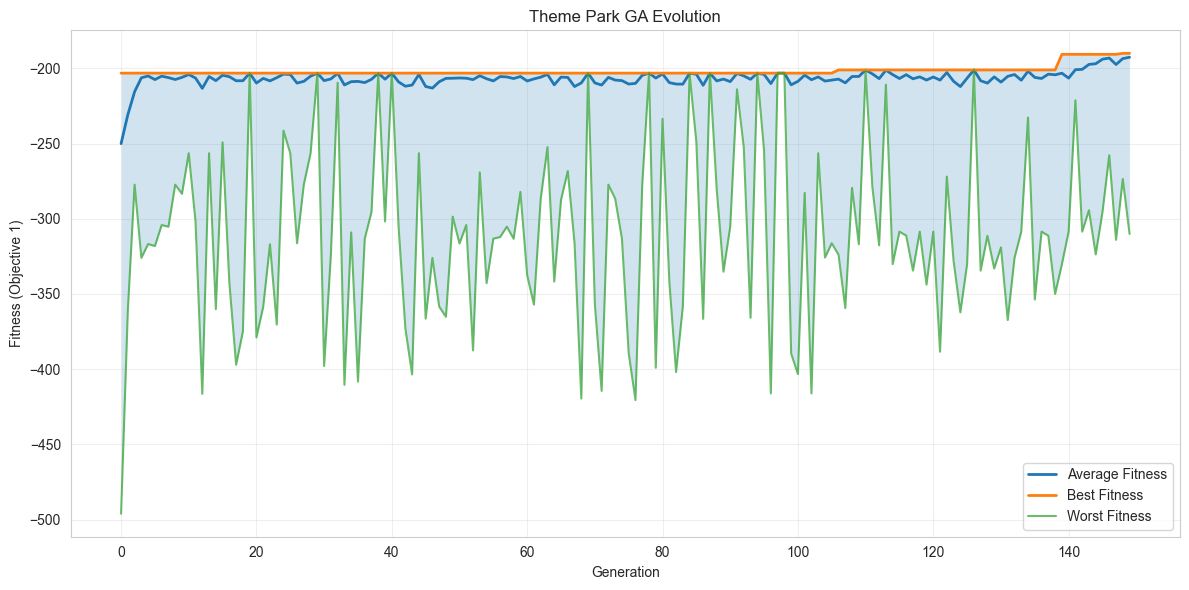

In [ ]:
import random
import time

# ============================================================================
# GENETIC ALGORITHM IMPLEMENTATION WITH DEAP
# ============================================================================

# Create fitness classes for DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def create_individual():
    """
    Create a valid individual (tour) using intelligent construction.
    Uses value-based greedy to seed population with good solutions.
    """
    attractions = df_attractions['name'].tolist()
    
    # Start with value-based greedy construction
    selected = []
    remaining = attractions.copy()
    current_location = 'Entrance'
    current_time = PARK_OPEN
    
    while remaining:
        # Calculate value for each remaining attraction
        best_attraction = None
        best_value = -1
        
        for attraction in remaining:
            # Estimate time to visit
            walk_time = df_distances.loc[current_location, attraction] / WALK_SPEED
            arrival_time = current_time + walk_time / 60
            wait_time = get_wait_time(attraction, arrival_time)
            ride_time = df_attractions[df_attractions['name'] == attraction]['ride_duration'].values[0]
            total_time = walk_time + wait_time + ride_time
            
            # Get preference
            preference = df_attractions[df_attractions['name'] == attraction]['preference'].values[0]
            
            # Calculate value with some randomness for diversity
            base_value = preference / max(total_time, 1)
            randomized_value = base_value * random.uniform(0.8, 1.2)
            
            if randomized_value > best_value:
                best_value = randomized_value
                best_attraction = attraction
        
        if best_attraction is None:
            break
            
        # Check if we can still visit this attraction
        walk_time = df_distances.loc[current_location, best_attraction] / WALK_SPEED
        current_time += walk_time / 60
        wait_time = get_wait_time(best_attraction, current_time)
        current_time += wait_time / 60
        ride_time = df_attractions[df_attractions['name'] == best_attraction]['ride_duration'].values[0]
        current_time += ride_time / 60
        
        # Check time constraint
        walk_back = df_distances.loc[best_attraction, 'Entrance'] / WALK_SPEED
        total_time_so_far = (current_time - PARK_OPEN) * 60 + walk_back
        
        if total_time_so_far > MAX_TIME_MINUTES:
            break
            
        selected.append(best_attraction)
        remaining.remove(best_attraction)
        current_location = best_attraction
    
    # Add some random mutations to create diversity
    if len(selected) > 2 and random.random() < 0.3:
        # Random swap
        i, j = random.sample(range(len(selected)), 2)
        selected[i], selected[j] = selected[j], selected[i]
    
    return creator.Individual(selected)

def evaluate_individual(individual):
    """Evaluate fitness of an individual (tour)."""
    if not individual:
        return (0.0,)
    
    try:
        result = calculate_total_time(individual)
        # Use objective 1 (preference - alpha * time) as fitness
        return (result['objective_1'],)
    except:
        return (0.0,)

def cx_order(ind1, ind2):
    """Order crossover (OX) - preserves relative order from parents."""
    size = min(len(ind1), len(ind2))
    if size < 2:
        return ind1, ind2
    
    # Choose random crossover points
    cxpoint1 = random.randint(0, size - 1)
    cxpoint2 = random.randint(cxpoint1 + 1, size)
    
    # Create children
    child1 = [None] * size
    child2 = [None] * size
    
    # Copy segments
    child1[cxpoint1:cxpoint2] = ind1[cxpoint1:cxpoint2]
    child2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2]
    
    # Fill remaining positions maintaining order
    def fill_child(child, other_parent):
        remaining = [item for item in other_parent if item not in child]
        remaining_idx = 0
        for i in range(size):
            if child[i] is None:
                child[i] = remaining[remaining_idx]
                remaining_idx += 1
    
    fill_child(child1, ind2)
    fill_child(child2, ind1)
    
    return creator.Individual(child1), creator.Individual(child2)

def mut_shuffle_indexes(individual, indpb=0.2):
    """Mutation by shuffling random subsequence."""
    if len(individual) < 2:
        return individual,
    
    if random.random() < indpb:
        # Choose random subsequence
        start = random.randint(0, len(individual) - 2)
        end = random.randint(start + 1, len(individual))
        
        # Shuffle the subsequence
        subseq = individual[start:end]
        random.shuffle(subseq)
        individual[start:end] = subseq
    
    return individual,

def mut_insert(individual, indpb=0.1):
    """Mutation by inserting element at different position."""
    if len(individual) < 2:
        return individual,
        
    if random.random() < indpb:
        # Pick random element and new position
        old_pos = random.randint(0, len(individual) - 1)
        new_pos = random.randint(0, len(individual) - 1)
        
        # Move element
        element = individual.pop(old_pos)
        individual.insert(new_pos, element)
    
    return individual,

def combined_mutation(individual, indpb=0.3):
    """Combined mutation applying multiple operators."""
    # Apply shuffle mutation
    individual, = mut_shuffle_indexes(individual, indpb * 0.7)
    # Apply insert mutation  
    individual, = mut_insert(individual, indpb * 0.3)
    return individual,

def run_genetic_algorithm(pop_size=50, generations=100, cxpb=0.7, mutpb=0.3, verbose=True):
    """
    Run genetic algorithm for theme park optimization.
    
    Args:
        pop_size: Population size
        generations: Number of generations
        cxpb: Crossover probability
        mutpb: Mutation probability
        verbose: Print progress
    
    Returns:
        Best individual and statistics
    """
    # Create toolbox
    toolbox = base.Toolbox()
    toolbox.register("individual", create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", cx_order)
    toolbox.register("mutate", combined_mutation)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Initialize population
    if verbose:
        print("🧬 Initializing genetic algorithm...")
        print(f"   Population size: {pop_size}")
        print(f"   Generations: {generations}")
        print(f"   Crossover probability: {cxpb}")
        print(f"   Mutation probability: {mutpb}")
    
    population = toolbox.population(n=pop_size)
    
    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    # Evolution tracking
    generation_stats = []
    best_individual = None
    best_fitness = -float('inf')
    
    start_time = time.time()
    
    for gen in range(generations):
        # Elitism: preserve best individual
        elite = tools.selBest(population, 1)

        # Selection: select pop_size - 1 to make room for elite
        offspring = toolbox.select(population, len(population) - 1)
        offspring = list(map(toolbox.clone, offspring))
        
        # Crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Mutation
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate invalid individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Replace population: elite + offspring (total = pop_size)
        population[:] = list(elite) + offspring
        
        # Gather statistics ONCE per generation
        record = stats.compile(population)
        generation_stats.append(record)
        
        # Track best individual
        gen_best = max(population, key=lambda x: x.fitness.values[0])
        if gen_best.fitness.values[0] > best_fitness:
            best_fitness = gen_best.fitness.values[0]
            best_individual = toolbox.clone(gen_best)
        
        # Print progress
        if verbose and (gen % 20 == 0 or gen == generations - 1):
            print(f"   Gen {gen:3d}: avg={record['avg']:.2f}, max={record['max']:.2f}, std={record['std']:.2f}")
    
    elapsed_time = time.time() - start_time
    
    if verbose:
        print(f"\n✅ Evolution completed in {elapsed_time:.2f}s")
        print(f"   Best fitness: {best_fitness:.2f}")
        print(f"   Best tour length: {len(best_individual)} attractions")
    
    return best_individual, generation_stats, elapsed_time


# ============================================================================
# ANALYSIS
# ============================================================================

def plot_evolution(generation_stats, title="Genetic Algorithm Evolution"):
    """Plot evolution statistics."""
    generations = range(len(generation_stats))
    avg_fitness = [stats['avg'] for stats in generation_stats]
    max_fitness = [stats['max'] for stats in generation_stats]
    min_fitness = [stats['min'] for stats in generation_stats]
    
    plt.figure(figsize=(12, 6))
    plt.plot(generations, avg_fitness, label='Average Fitness', linewidth=2)
    plt.plot(generations, max_fitness, label='Best Fitness', linewidth=2)
    plt.plot(generations, min_fitness, label='Worst Fitness', alpha=0.7)
    plt.fill_between(generations, min_fitness, max_fitness, alpha=0.2)
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Objective 1)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# RUN GENETIC ALGORITHM DIRECTLY
# ============================================================================

print("\n🧬 Running Genetic Algorithm for Theme Park Optimization")
print("="*70)

# Run genetic algorithm directly
ga_best, ga_stats, ga_time = run_genetic_algorithm(
    pop_size=60, 
    generations=150, 
    verbose=True
)

# Evaluate the best solution
ga_result = calculate_total_time(ga_best)

print("\n" + "="*70)
print("🏆 GENETIC ALGORITHM RESULTS")
print("="*70)
print(f"Tour: {ga_best}")
print(f"Attractions Visited: {len(ga_best)}")
print(f"Total Preference: {ga_result['total_preference']}")
print(f"Total Time: {ga_result['total_time']:.1f} minutes ({ga_result['total_time']/60:.1f} hours)")
print(f"Objective 1 Score: {ga_result['objective_1']:.2f}")
print(f"Runtime: {ga_time:.2f} seconds")

# Check if within time constraints
if ga_result['total_time'] <= MAX_TIME_MINUTES:
    spare_time = MAX_TIME_MINUTES - ga_result['total_time']
    print(f"   ✅ Within park hours ({spare_time:.1f} minutes to spare)")
else:
    overtime = ga_result['total_time'] - MAX_TIME_MINUTES
    print(f"   ⚠️  Exceeds park hours by {overtime:.1f} minutes")

# Plot genetic algorithm evolution
plot_evolution(ga_stats, "Theme Park GA Evolution")



## Greedy + 2-opt Optimization Implementation

In [12]:
import time

# ============================================================================
# GREEDY CONSTRUCTION ALGORITHMS
# ============================================================================

def greedy_nearest_neighbor(start_hour=PARK_OPEN, time_limit=MAX_TIME_MINUTES):
    """
    Greedy algorithm: Always visit the nearest unvisited attraction.
    
    Returns: List of attraction names in visit order
    """
    itinerary = []
    visited = set()
    current_location = 'Entrance'
    current_time = start_hour
    
    attractions_list = df_attractions['name'].tolist()
    
    while len(visited) < len(attractions_list):
        # Find nearest unvisited attraction
        best_attraction = None
        best_distance = float('inf')
        
        for attraction in attractions_list:
            if attraction not in visited:
                distance = df_distances.loc[current_location, attraction]
                if distance < best_distance:
                    best_distance = distance
                    best_attraction = attraction
        
        if best_attraction is None:
            break
        
        # Simulate visiting this attraction
        walk_time = df_distances.loc[current_location, best_attraction] / WALK_SPEED
        current_time += walk_time / 60
        
        wait_time = get_wait_time(best_attraction, current_time)
        current_time += wait_time / 60
        
        ride_time = df_attractions[df_attractions['name'] == best_attraction]['ride_duration'].values[0]
        current_time += ride_time / 60
        
        # Check time constraint
        walk_back = df_distances.loc[best_attraction, 'Entrance']
        total_time_so_far = (current_time - start_hour) * 60 + walk_back
        
        if total_time_so_far > time_limit:
            break  # Would exceed time limit
        
        # Add to itinerary
        itinerary.append(best_attraction)
        visited.add(best_attraction)
        current_location = best_attraction
    
    return itinerary


def greedy_best_preference(start_hour=PARK_OPEN, time_limit=MAX_TIME_MINUTES):
    """
    Greedy algorithm: Always visit highest preference unvisited attraction.
    
    Returns: List of attraction names in visit order
    """
    itinerary = []
    visited = set()
    current_location = 'Entrance'
    current_time = start_hour
    
    # Sort attractions by preference (descending)
    attractions_sorted = df_attractions.sort_values('preference', ascending=False)
    
    for _, row in attractions_sorted.iterrows():
        attraction = row['name']
        
        if attraction in visited:
            continue
        
        # Simulate visiting this attraction
        walk_time = df_distances.loc[current_location, attraction] / WALK_SPEED
        current_time += walk_time / 60
        
        wait_time = get_wait_time(attraction, current_time)
        current_time += wait_time / 60
        
        ride_time = row['ride_duration']
        current_time += ride_time / 60
        
        # Check time constraint
        walk_back = df_distances.loc[attraction, 'Entrance']
        total_time_so_far = (current_time - start_hour) * 60 + walk_back
        
        if total_time_so_far > time_limit:
            break  # Would exceed time limit
        
        # Add to itinerary
        itinerary.append(attraction)
        visited.add(attraction)
        current_location = attraction
    
    return itinerary


def greedy_value_based(start_hour=PARK_OPEN, time_limit=MAX_TIME_MINUTES):
    """
    Smart greedy: Calculate value = preference / total_time_to_ride
    Visit highest value unvisited attraction.
    
    Returns: List of attraction names in visit order
    """
    itinerary = []
    visited = set()
    current_location = 'Entrance'
    current_time = start_hour
    
    attractions_list = df_attractions['name'].tolist()
    
    while len(visited) < len(attractions_list):
        # Calculate value for each unvisited attraction
        best_attraction = None
        best_value = -float('inf')
        
        for attraction in attractions_list:
            if attraction in visited:
                continue
            
            # Estimate time to ride this attraction
            walk_time = df_distances.loc[current_location, attraction] / WALK_SPEED
            arrival_time = current_time + walk_time / 60
            wait_time = get_wait_time(attraction, arrival_time)
            ride_time = df_attractions[df_attractions['name'] == attraction]['ride_duration'].values[0]
            total_time = walk_time + wait_time + ride_time
            
            # Get preference
            preference = df_attractions[df_attractions['name'] == attraction]['preference'].values[0]
            
            # Calculate value (preference per unit time)
            value = preference / max(total_time, 1)  # Avoid division by zero
            
            if value > best_value:
                best_value = value
                best_attraction = attraction
        
        if best_attraction is None:
            break
        
        # Simulate visiting this attraction
        walk_time = df_distances.loc[current_location, best_attraction]
        current_time += walk_time / 60
        
        wait_time = get_wait_time(best_attraction, current_time)
        current_time += wait_time / 60
        
        ride_time = df_attractions[df_attractions['name'] == best_attraction]['ride_duration'].values[0]
        current_time += ride_time / 60
        
        # Check time constraint
        walk_back = df_distances.loc[best_attraction, 'Entrance']
        total_time_so_far = (current_time - start_hour) * 60 + walk_back
        
        if total_time_so_far > time_limit:
            break  # Would exceed time limit
        
        # Add to itinerary
        itinerary.append(best_attraction)
        visited.add(best_attraction)
        current_location = best_attraction
    
    return itinerary


# ============================================================================
# 2-OPT LOCAL SEARCH
# ============================================================================

def two_opt(itinerary, max_iterations=100):
    """
    2-opt local search: Improve tour by reversing segments.
    
    Args:
        itinerary: Initial tour (list of attraction names)
        max_iterations: Maximum number of improvement iterations
        
    Returns: Improved tour
    """
    if len(itinerary) < 3:
        return itinerary  # Can't improve tours with < 3 attractions
    
    best_itinerary = itinerary.copy()
    best_score = calculate_total_time(best_itinerary)['objective_1']
    
    improved = True
    iteration = 0
    
    while improved and iteration < max_iterations:
        improved = False
        iteration += 1
        
        # Try all possible 2-opt swaps
        for i in range(len(best_itinerary) - 1):
            for j in range(i + 2, len(best_itinerary) + 1):
                # Create new tour by reversing segment [i+1:j]
                new_itinerary = best_itinerary[:i+1] + best_itinerary[i+1:j][::-1] + best_itinerary[j:]
                
                # Evaluate new tour
                try:
                    new_score = calculate_total_time(new_itinerary)['objective_1']
                    
                    # If better, keep it
                    if new_score > best_score:
                        best_itinerary = new_itinerary
                        best_score = new_score
                        improved = True
                        break  # Restart search from beginning
                except:
                    pass  # Skip invalid tours
            
            if improved:
                break
    
    return best_itinerary


# ============================================================================
# COMBINED GREEDY + 2-OPT
# ============================================================================

def optimize_greedy_2opt(greedy_method='value', use_2opt=True, verbose=True):
    """
    Run greedy construction + 2-opt improvement.
    
    Args:
        greedy_method: 'nearest', 'preference', or 'value'
        use_2opt: Whether to apply 2-opt improvement
        verbose: Print results
        
    Returns: Best itinerary and results dictionary
    """
    start_time = time.time()
    
    # Phase 1: Greedy construction
    if greedy_method == 'nearest':
        itinerary = greedy_nearest_neighbor()
        method_name = "Nearest Neighbor Greedy"
    elif greedy_method == 'preference':
        itinerary = greedy_best_preference()
        method_name = "Best Preference Greedy"
    else:  # value
        itinerary = greedy_value_based()
        method_name = "Value-Based Greedy"
    
    greedy_result = calculate_total_time(itinerary)
    greedy_time = time.time() - start_time
    
    # Phase 2: 2-opt improvement (optional)
    if use_2opt and len(itinerary) >= 20:
        improved_itinerary = two_opt(itinerary)
        improved_result = calculate_total_time(improved_itinerary)
        total_time = time.time() - start_time
    else:
        improved_itinerary = itinerary
        improved_result = greedy_result
        total_time = greedy_time
    
    # Print results
    if verbose:
        print("=" * 70)
        print(f"OPTIMIZATION: {method_name}" + (" + 2-opt" if use_2opt else ""))
        print("=" * 70)
        
        print(f"\n📍 Greedy Solution ({greedy_time:.3f}s):")
        print(f"   Itinerary: {itinerary}")
        print(f"   Preference: {greedy_result['total_preference']}")
        print(f"   Time: {greedy_result['total_time']:.1f} min")
        print(f"   Objective 1: {greedy_result['objective_1']:.2f}")
        
        if use_2opt and len(itinerary) >= 3:
            improvement = improved_result['objective_1'] - greedy_result['objective_1']
            print(f"\n🔧 After 2-opt ({total_time:.3f}s):")
            print(f"   Itinerary: {improved_itinerary}")
            print(f"   Preference: {improved_result['total_preference']}")
            print(f"   Time: {improved_result['total_time']:.1f} min")
            print(f"   Objective 1: {improved_result['objective_1']:.2f}")
            print(f"   Improvement: {'+' if improvement >= 0 else ''}{improvement:.2f}")
        
        print(f"\n⏱️  Total computation time: {total_time:.3f}s")
        print("=" * 70)
    
    return improved_itinerary, improved_result


# Test all three greedy methods
print("\n\n")
print("#" * 70)
print("# TESTING ALL OPTIMIZATION METHODS")
print("#" * 70)
print("\n")

results = {}

# Test 1: Nearest Neighbor
it1, res1 = optimize_greedy_2opt('nearest', use_2opt=True)
results['Nearest + 2-opt'] = res1

print("\n\n")

# Test 2: Best Preference
it2, res2 = optimize_greedy_2opt('preference', use_2opt=True)
results['Preference + 2-opt'] = res2

print("\n\n")

# Test 3: Value-based
it3, res3 = optimize_greedy_2opt('value', use_2opt=True)
results['Value + 2-opt'] = res3

print("\n\n")

# Summary comparison
print("=" * 70)
print("SUMMARY: COMPARISON OF ALL METHODS")
print("=" * 70)
print("\n{:<25} {:<12} {:<12} {:<12}".format("Method", "Preference", "Time (min)", "Objective 1"))
print("-" * 70)

for method_name, result in results.items():
    print("{:<25} {:<12} {:<12.1f} {:<12.2f}".format(
        method_name,
        result['total_preference'],
        result['total_time'],
        result['objective_1']
    ))

# Find best method
best_method = max(results.items(), key=lambda x: x[1]['objective_1'])
print("\n🏆 Best method: {} (Objective 1 = {:.2f})".format(
    best_method[0], best_method[1]['objective_1']
))
print("=" * 70)




######################################################################
# TESTING ALL OPTIMIZATION METHODS
######################################################################


OPTIMIZATION: Nearest Neighbor Greedy + 2-opt

📍 Greedy Solution (0.009s):
   Itinerary: ['AlpenFury', 'Thunder Run', 'Krachenwagen', 'The Bat', 'Leviathan', 'Drop Tower', 'Dragon Fyre', 'Vortex', 'Lumberjack', 'The Fly', "Wonder Mountain's Guardian", 'Skyhawk', 'WindSeeker']
   Preference: 52
   Time: 667.2 min
   Objective 1: -14.72

🔧 After 2-opt (0.009s):
   Itinerary: ['AlpenFury', 'Thunder Run', 'Krachenwagen', 'The Bat', 'Leviathan', 'Drop Tower', 'Dragon Fyre', 'Vortex', 'Lumberjack', 'The Fly', "Wonder Mountain's Guardian", 'Skyhawk', 'WindSeeker']
   Preference: 52
   Time: 667.2 min
   Objective 1: -14.72
   Improvement: +0.00

⏱️  Total computation time: 0.009s



OPTIMIZATION: Best Preference Greedy + 2-opt

📍 Greedy Solution (0.007s):
   Itinerary: ['AlpenFury', "Snoopy's Racing Railway", 'Lev